# 연습문제2 — ECOS 데이터 실습 (501Y001, ZZZ00)

**주의(변경 금지)**: 고정 파라미터는 변경하지 마세요. 학생은 `api_key`만 본인 키로 교체합니다.

목표: stat_code=`501Y001`, item_code1=`ZZZ00` (전산업)을 2009-2023년 기간 받아 연도별로 **같은 연도의 여러 세부 항목을 집계(sum & mean)** 한 뒤, 연도 단위 시계열에 대해 결측 대체, 3년 이동평균, 전년대비(%)을 계산하고 시각화/분석 결과를 제출합니다.

출력 파일:
- `ecos_501Y001_ZZZ00_annual_cleaned.csv`
- `timeseries_501Y001_ZZZ00.png`
- `annual_bar_501Y001_ZZZ00.png`

노트: 셀을 순서대로 실행하세요. 함수형태는 사용하지 않았습니다.

In [1]:
# 셀 1: 라이브러리 임포트 및 설정
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
sns.set_style('whitegrid')


API_KEY = "Q5M1FTDZTGXSQ7D55I3J"
BASE = "https://ecos.bok.or.kr/api"


STAT_CODE = '501Y001'
FREQ = 'A'
ITEM_CODE1 = 'ZZZ00'
START = '2009'
END = '2023'

In [24]:
base = f"{BASE}/StatisticSearch"
url = f"{base}/{API_KEY}/json/kr/1/9999/{STAT_CODE}/A/{START}/{END}/{ITEM_CODE1}"
url

'https://ecos.bok.or.kr/api/StatisticSearch/Q5M1FTDZTGXSQ7D55I3J/json/kr/1/9999/501Y001/A/2009/2023/ZZZ00'

In [25]:
r = requests.get(url, timeout=30)

data = r.json()
# data

{'StatisticSearch': {'list_total_count': 2009,
  'row': [{'STAT_CODE': '501Y001',
    'STAT_NAME': '5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)',
    'ITEM_CODE1': 'ZZZ00',
    'ITEM_NAME1': '전산업',
    'ITEM_CODE2': 'A',
    'ITEM_NAME2': '종합',
    'ITEM_CODE3': '110000',
    'ITEM_NAME3': '자산총계',
    'ITEM_CODE4': None,
    'ITEM_NAME4': None,
    'UNIT_NAME': '백만원',
    'WGT': None,
    'TIME': '2009',
    'DATA_VALUE': '2995852121'},
   {'STAT_CODE': '501Y001',
    'STAT_NAME': '5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)',
    'ITEM_CODE1': 'ZZZ00',
    'ITEM_NAME1': '전산업',
    'ITEM_CODE2': 'A',
    'ITEM_NAME2': '종합',
    'ITEM_CODE3': '111000',
    'ITEM_NAME3': '유동자산',
    'ITEM_CODE4': None,
    'ITEM_NAME4': None,
    'UNIT_NAME': '백만원',
    'WGT': None,
    'TIME': '2009',
    'DATA_VALUE': '1326274126'},
   {'STAT_CODE': '501Y001',
    'STAT_NAME': '5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)',
    'ITEM_CODE1': 'ZZZ00',
    'ITEM_NAME1': '전산업',
    'ITEM_CODE2': 'A',
    'ITEM_NAME2': '종합',
    'ITE

In [ ]:
rows = data['StatisticSearch'].get('row', [])
if isinstance(rows, dict):
    rows = [rows]
df_raw = pd.DataFrame(rows)
df_raw.head()

In [26]:
df = df_raw.copy()

In [30]:
df['TIME'] = df['TIME'].astype(str)
df['year'] = df['TIME'].str.slice(0,4).astype(int)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-01-01')

In [31]:
val_col ='DATA_VALUE'

In [32]:
df['value'] = pd.to_numeric(df[val_col].astype(str).str.replace(',','').replace('', np.nan), errors='coerce')
df.head()


STAT_CODE                           STAT_NAME ITEM_CODE1 ITEM_NAME1  \
0   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
1   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
2   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
3   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   
4   501Y001  5.3.1. 재무상태표(제10차 한국표준산업분류, 2009~)      ZZZ00        전산업   

  ITEM_CODE2 ITEM_NAME2 ITEM_CODE3 ITEM_NAME3 ITEM_CODE4 ITEM_NAME4 UNIT_NAME  \
0          A         종합     110000       자산총계       None       None       백만원   
1          A         종합     111000       유동자산       None       None       백만원   
2          A         종합     111100       당좌자산       None       None       백만원   
3          A         종합     111130       매출채권       None       None       백만원   
4          A         종합     111150   현금.현금성자산       None       None       백만원   

    WGT  TIME  DATA_VALUE       value  year       date  
0  None  2009  2995852121  2995852121  2009 2009-01-01  
1  None  2009  1326274126  1326274126  2009 2009-01-01  
2  None  2009   920019568   920019568  2009 2009-01-01  
3  None  2009   390626120   390626120  2009 2009-01-01  
4  None  2009   167306000   167306000  2009 2009-01-01

In [33]:
# 연도별 집계 — sum, mean, count
agg = df.groupby('year')['value'].agg(['sum','mean','count']).reset_index()

In [36]:
agg['date'] = pd.to_datetime(agg['year'].astype(str) + '-01-01')

In [37]:
agg = agg.set_index('date').sort_index()

In [38]:
agg = agg.rename(columns={'sum':'value_sum','mean':'value_mean','count':'value_count'})

In [39]:
agg.head()

year    value_sum    value_mean  value_count
date                                                    
2009-01-01  2009  42661363478  3.468404e+08          123
2010-01-01  2010  46177477744  3.754266e+08          123
2011-01-01  2011  50195843305  4.080963e+08          123
2012-01-01  2012  52709272739  4.285307e+08          123
2013-01-01  2013  55442147656  4.507492e+08          123

In [ ]:
start = int(START)
end = int(END)
years = pd.date_range(start=f"{start}-01-01", end=f"{end}-01-01", freq='YS')
annual = agg.reindex(years)
annual['year'] = annual.index.year

In [ ]:
annual['value'] = annual['value_sum']

In [ ]:
mean_val = annual['value'].mean(skipna=True)
annual['value_filled'] = annual['value'].fillna(mean_val)

In [40]:
# 3-year moving average & YoY (on value_filled)
annual['ma_3'] = annual['value_filled'].rolling(window=3, min_periods=1).mean()
annual['pct_yoy'] = annual['value_filled'].pct_change(periods=1) * 100

annual.head()

year    value_sum    value_mean  value_count        value  \
2009-01-01  2009  42661363478  3.468404e+08          123  42661363478   
2010-01-01  2010  46177477744  3.754266e+08          123  46177477744   
2011-01-01  2011  50195843305  4.080963e+08          123  50195843305   
2012-01-01  2012  52709272739  4.285307e+08          123  52709272739   
2013-01-01  2013  55442147656  4.507492e+08          123  55442147656   

            value_filled          ma_3   pct_yoy  
2009-01-01   42661363478  4.266136e+10       NaN  
2010-01-01   46177477744  4.441942e+10  8.241917  
2011-01-01   50195843305  4.634489e+10  8.702003  
2012-01-01   52709272739  4.969420e+10  5.007246  
2013-01-01   55442147656  5.278242e+10  5.184809

In [12]:
out_fname = 'ecos_501Y001_ZZZ00_annual_cleaned.csv'
save_df = annual.reset_index()

save_df['TIME'] = save_df['year'].astype(str)
save_cols = ['TIME','year','index','value','value_filled','ma_3','pct_yoy']
save_df = save_df.rename(columns={'index':'date'})
save_df = save_df[['TIME','year','date','value','value_filled','ma_3','pct_yoy']]
save_df.to_csv(out_fname, index=False, encoding='utf-8-sig')


In [13]:
from google.colab import files
files.download(out_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

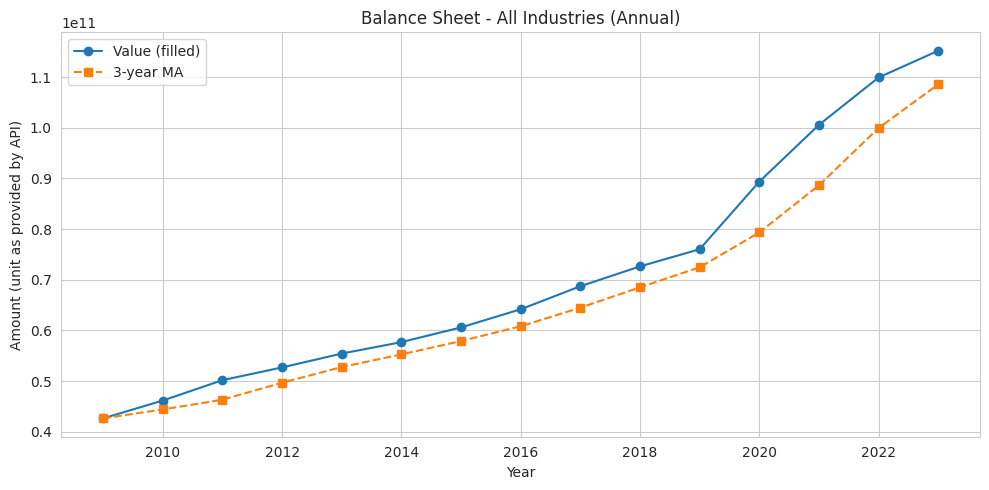

In [41]:
plt.figure(figsize=(10,5))
plt.plot(annual['year'], annual['value_filled'], marker='o', label='Value (filled)')
plt.plot(annual['year'], annual['ma_3'], marker='s', linestyle='--', label='3-year MA')
plt.title('Balance Sheet - All Industries (Annual)')
plt.xlabel('Year')
plt.ylabel('Amount (unit as provided by API)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


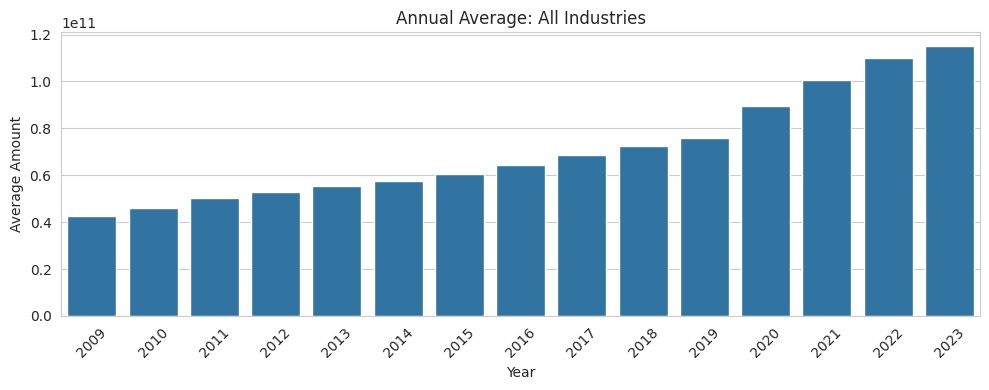

In [42]:
annual_bar = annual['value_filled'].resample('YE').mean()
annual_bar.index = annual_bar.index.year
plt.figure(figsize=(10,4))
sns.barplot(x=annual_bar.index.astype(str), y=annual_bar.values)
plt.xticks(rotation=45)
plt.title('Annual Average: All Industries')
plt.xlabel('Year')
plt.ylabel('Average Amount')
plt.tight_layout()
plt.savefig('annual_bar_501Y001_ZZZ00.png', dpi=150)
plt.show()


In [43]:
# 수치 분석 — 최신값, 전년값, YoY, Recent/Previous 3-year means
latest_year = int(END)
# if latest_year in annual['year'].values:
#     latest_val = float(annual.loc[annual['year']==latest_year,'value_filled'].iloc[0])
# else:
#     latest_val = np.nan

latest_val = float(annual.loc[annual['year']==latest_year,'value_filled'].iloc[0])

prev_year = latest_year - 1
if prev_year in annual['year'].values:
    prev_val = float(annual.loc[annual['year']==prev_year,'value_filled'].iloc[0])
else:
    prev_val = np.nan

prev_val = float(annual.loc[annual['year']==prev_year,'value_filled'].iloc[0])

if pd.notna(prev_val) and prev_val != 0:
    yoy_latest = (latest_val - prev_val) / prev_val * 100
else:
    yoy_latest = np.nan

yoy_latest = (latest_val - prev_val) / prev_val * 100




In [44]:
latest_year, latest_val, prev_val, yoy_latest

(2023, 115204944281.0, 109920164574.0, 4.807834602032644)

In [45]:
recent_mask = (annual['year']>=2021) & (annual['year']<=2023)
prev_mask = (annual['year']>=2018) & (annual['year']<=2020)
mean_recent_3 = annual.loc[recent_mask,'value_filled'].mean()
mean_prev_3 = annual.loc[prev_mask,'value_filled'].mean()
if pd.notna(mean_prev_3) and mean_prev_3 != 0:
    change_rate_3y = (mean_recent_3 - mean_prev_3) / mean_prev_3 * 100
else:
    change_rate_3y = np.nan

In [22]:
mean_recent_3, mean_prev_3, change_rate_3y

(np.float64(108566206436.0),
 np.float64(79347630794.0),
 np.float64(36.823501029106225))

In [46]:
print('Latest year:', latest_year)
print('Latest value (filled):', latest_val)
print('Previous year value:', prev_val)
print('YoY % (latest):', yoy_latest)
print('\nRecent 3-year mean (2021-2023):', mean_recent_3)
print('Previous 3-year mean (2018-2020):', mean_prev_3)
print('3-year change rate (%):', change_rate_3y)

Latest year: 2023
Latest value (filled): 115204944281.0
Previous year value: 109920164574.0
YoY % (latest): 4.807834602032644

Recent 3-year mean (2021-2023): 108566206436.0
Previous 3-year mean (2018-2020): 79347630794.0
3-year change rate (%): 36.823501029106225
